# Convolutional Neural Network  Model

## Import Dependencies

In [ ]:
# Note: Make sure the dataset path matches your local setup

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm.auto import tqdm
from torchvision.transforms import v2
from timeit import default_timer as timer
import random
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Data Transform

In [ ]:
def plot_transformed_image(image_path: Path, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_path, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(img, cmap="gray")
            ax[0].set_title(f"Original \nSize: {img.size}")
            ax[0].axis("off")

            transformed_image = transform(img)  # tensor shape [C, H, W]
            full_shape = tuple(transformed_image.shape)

            # If it's grayscale (1 channel), squeeze for display
            if transformed_image.shape[0] == 1:
                display_image = transformed_image.squeeze(0)
                ax[1].imshow(display_image, cmap="gray")
            else:
                # Permute to [H, W, C] for RGB display
                display_image = transformed_image.permute(1, 2, 0)
                ax[1].imshow(display_image)

            ax[1].set_title(f"Transformed \nShape: {full_shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)

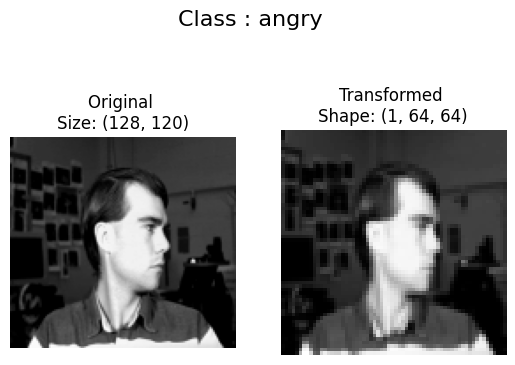

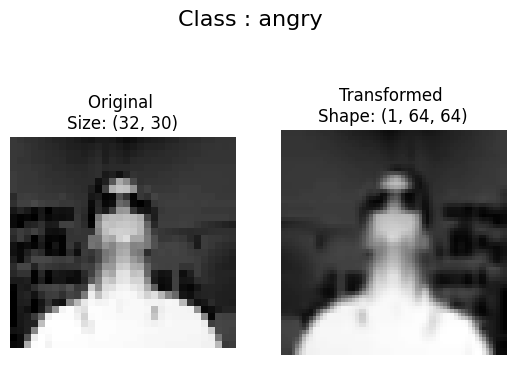

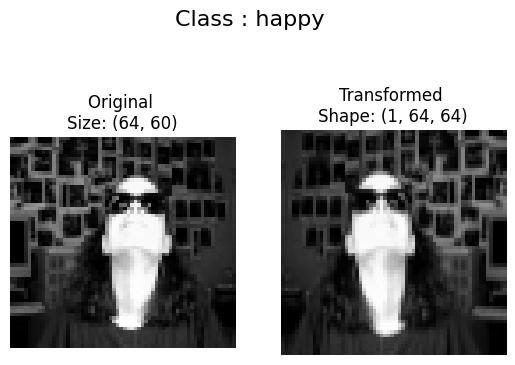

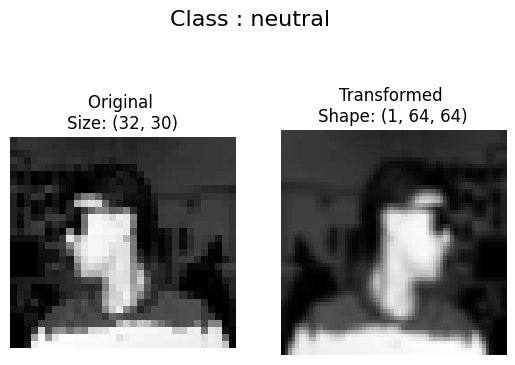

In [ ]:
train_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/train")
test_images_path = [f for f in train_dir.rglob("*.png")]

# Image.open(test_images_path[1])

data_transform_v0 = v2.Compose([
    # for grayscale
    v2.Grayscale(num_output_channels=1),

    # resize image
    v2.Resize(size=(64, 64)),

    # flip images
    v2.RandomHorizontalFlip(p=0.5),

    # turn image to torch tensor
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

plot_transformed_image(image_path=test_images_path,
                       transform=data_transform_v0,
                       seed=None,
                       n=4)

## Load Dataset Into Dataloader & Imagefolder

In [ ]:
train_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/train")
test_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/test")
validation_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/validation")

train_dataset = ImageFolder(root=train_dir,
                            transform=data_transform_v0,
                            target_transform=None,
                            allow_empty=True)

validation_dataset = ImageFolder(root=validation_dir,
                            transform=data_transform_v0,
                            target_transform=None,
                            allow_empty=True)

test_dataset = ImageFolder(root=test_dir,
                            transform=data_transform_v0,
                            target_transform=None,
                            allow_empty=True)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              num_workers=1,
                              shuffle=True)

validation_dataloader = DataLoader(dataset=validation_dataset,
                              batch_size=16,
                              num_workers=1,
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=16,
                              num_workers=1,
                              shuffle=False)

In [ ]:
# without 32 x 30 pixel

test_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/test_without_32")
validation_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/validation_without_32")
train_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/train_without_32")

train_dataset = ImageFolder(root=train_dir,
                            transform=data_transform_v0,
                            target_transform=None,
                            allow_empty=True)

validation_dataset = ImageFolder(root=validation_dir,
                            transform=data_transform_v0,
                            target_transform=None,
                            allow_empty=True)

test_dataset = ImageFolder(root=test_dir,
                            transform=data_transform_v0,
                            target_transform=None,
                            allow_empty=True)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              num_workers=1,
                              shuffle=True)

validation_dataloader = DataLoader(dataset=validation_dataset,
                              batch_size=16,
                              num_workers=1,
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=16,
                              num_workers=1,
                              shuffle=False)

## TinyVGG_V0 Model

In [ ]:
class TinyVGG_V0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Feature extraction
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        # Activation function
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.LazyLinear(out_features=128),
      nn.ReLU(),
      nn.Linear(in_features=128, out_features=64),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(in_features=64, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.conv_block_1(x))

## Train The Model

In [ ]:
def train_step(dataloader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module, model: nn.Module, device: str = "cuda"):
  train_loss, train_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred_logits = model(X)

    # loss
    loss = loss_fn(y_pred_logits, y)
    train_loss += loss.item()

    # optimizer zero grad
    optimizer.zero_grad()

    # backprop
    loss.backward()

    # gradient descent
    optimizer.step()

    # we dont use softmax because we're using CrossEntropyLoss which already has applied softmax internally
    y_pred_class = torch.argmax(y_pred_logits, dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred_class)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

def test_step(dataloader: DataLoader, loss_fn: torch.nn.Module, model: nn.Module, device: str = "cuda"):
  model.to(device)
  test_loss, test_acc = 0, 0
  model.eval()

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred_logits = model(X)

      loss = loss_fn(y_pred_logits, y)
      test_loss += loss.item()

      test_pred = torch.argmax(y_pred_logits, dim=1)
      test_acc += ((test_pred == y).sum().item() / len(test_pred))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

def valid_step(model: nn.Module, loss_fn: torch.nn.Module, dataloader: DataLoader, device: str = "cuda"):
    model.eval()
    val_loss, val_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # converts to the correct device
            X, y = X.to(device), y.to(device)

            # forward
            val_pred_logits = model(X)

            # calculate loss and acc
            loss = loss_fn(val_pred_logits, y) # (pred, true)
            val_loss += loss.item()

            val_pred = torch.argmax(val_pred_logits, dim=1)
            val_acc += ((val_pred == y).sum().item() / len(val_pred))

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    return val_loss, val_acc

def train(optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          train_dataloader: DataLoader,
          validation_dataloader: DataLoader,
          n_epochs: int,
          model: nn.Module,
          early_stopping=None,
          scheduler: torch.optim = None,
          device: str = "cuda"):

    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    model = model.to(device)

    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = train_step(dataloader=train_dataloader,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           model=model,
                                           device=device)

        val_loss, val_acc = valid_step(dataloader=validation_dataloader,
                                       loss_fn=loss_fn,
                                       model=model,
                                       device=device)

        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch : {epoch} | Current_lr: {current_lr} | train_loss : {train_loss} | train_acc : {train_acc} | val_loss : {val_loss} | val_acc : {val_acc}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if early_stopping is not None:
            early_stopping.check_early_stop(val_loss)

            if early_stopping.stop_training:
                print(f"Early stopping at epoch : {epoch}")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

    if early_stopping is not None and not early_stopping.stop_training:
        print("Training completed. Saving best model (no early stop triggered).")
        torch.save({
            "model_state_dict": early_stopping.best_model_state,
            "best_loss": early_stopping.best_loss
        }, early_stopping.save_path)

    return results

In [ ]:
class EarlyStopping():
  def __init__(self, model: nn.Module, save_path: Path, patience=5, delta=0, verbose=False) -> None:
    self.patience = patience
    self.model = model
    self.save_path = save_path
    self.patience = patience
    self.delta = delta
    self.verbose = verbose
    self.best_loss = None
    self.no_improvement_count = 0
    self.stop_training = False
    self.best_model_state = None

  def check_early_stop(self, val_loss):
    if self.best_loss is None or val_loss < (self.best_loss - self.delta):
      self.no_improvement_count = 0
      self.best_model_state = copy.deepcopy(self.model.state_dict())
      self.best_loss = val_loss

      if self.verbose:
         print("New best model found. Validation loss:", val_loss)
    else:
      self.no_improvement_count += 1
      if self.no_improvement_count == self.patience:
        self.stop_training = True
        torch.save({
          "model_state_dict": self.best_model_state,
          "best_loss": self.best_loss
        }, self.save_path)

        if self.verbose:
          print("Stopping early as no improvement has been observed")
          print("Best Loss", self.best_loss)
          print("The best model has been saved")


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
SAVE_PATH = Path("/content/drive/MyDrive/ml_final_assignment/models/tinyVGG_v0.pth")
model_0 = TinyVGG_V0(input_shape=1,
                     output_shape=4,
                     hidden_units=64)

optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=4e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        factor=0.8,
        patience=3,
        threshold=1e-4
    )

earlyStopping = EarlyStopping(model=model_0,
                              save_path=SAVE_PATH,
                              delta=1e-4,
                              verbose=True,
                              patience=15)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 100

start_timer = timer()
model_0_results = train(model=model_0,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        train_dataloader=train_dataloader,
                        validation_dataloader=validation_dataloader,
                        early_stopping=earlyStopping,
                        scheduler=scheduler,
                        n_epochs=EPOCHS
                        )
end_timer = timer()

print(f"Total training time : {start_timer - end_timer:.2f} seconds")
print("Model 0 results : ", model_0_results)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0 | Current_lr: 0.0004 | train_loss : 1.393053338882771 | train_acc : 0.24202127659574468 | val_loss : 1.3875329792499542 | val_acc : 0.24479166666666666
New best model found. Validation loss: 1.3875329792499542
Epoch : 1 | Current_lr: 0.0004 | train_loss : 1.3874452976470297 | train_acc : 0.24534574468085107 | val_loss : 1.384799728790919 | val_acc : 0.2829861111111111
New best model found. Validation loss: 1.384799728790919
Epoch : 2 | Current_lr: 0.0004 | train_loss : 1.3890454642316128 | train_acc : 0.25199468085106386 | val_loss : 1.3863429923852284 | val_acc : 0.265625
Epoch : 3 | Current_lr: 0.0004 | train_loss : 1.3873889040439686 | train_acc : 0.2546542553191489 | val_loss : 1.3850910166899364 | val_acc : 0.3211805555555555
Epoch : 4 | Current_lr: 0.0004 | train_loss : 1.3844436609998663 | train_acc : 0.2632978723404255 | val_loss : 1.3791434069474537 | val_acc : 0.3090277777777778
New best model found. Validation loss: 1.3791434069474537
Epoch : 5 | Current_lr: 0.0004

## Plot Evaluation Curve

In [ ]:
def plot_eval_curves(results):
  train_loss = results["train_loss"]
  val_loss = results["val_loss"]

  train_acc = results["train_acc"]
  val_acc = results["val_acc"]

  epochs = range(len(train_loss))

  plt.figure(figsize=(15, 7))

  # Plot train vs val loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="train_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot train vs val acc
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label="train_accuracy")
  plt.plot(epochs, val_acc, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.tight_layout()

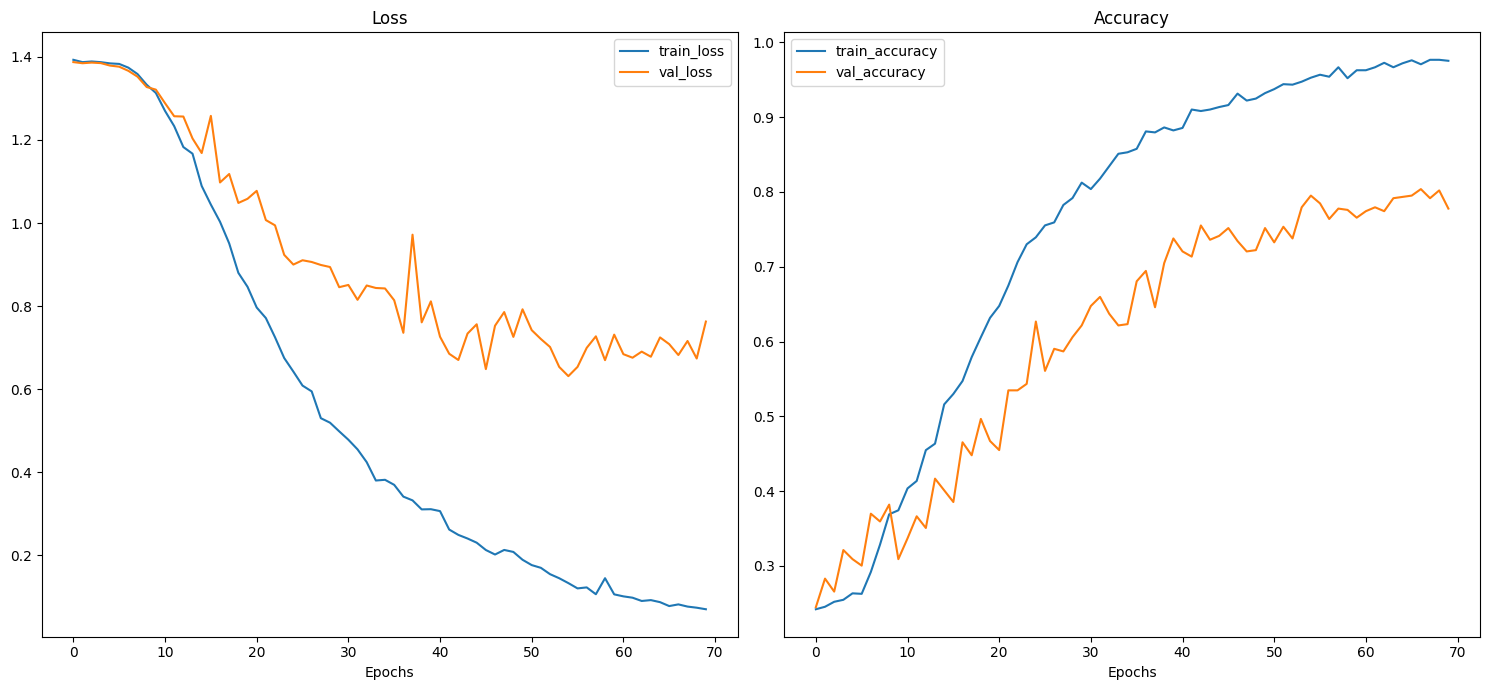

In [ ]:
plot_eval_curves(results=model_0_results)

## Save base model

In [ ]:
SAVE_PATH = Path("/content/drive/MyDrive/ml_final_assignment/models/tinyVGG_v0.pth")

torch.save({
    "model_state_dict": model_0.state_dict(),
    "results": model_0_results
}, SAVE_PATH)

## 🧪 TinyVGG_v0 Evaluation Summary
After training TinyVGG_v0 for 50 epochs (~2500 seconds), the model demonstrated strong learning capabilities on the training set but began to overfit on the validation set. Here's a breakdown:

### Loss:
- The training loss consistently decreased throughout the epochs, indicating effective learning.
- The validation loss, however, plateaued and fluctuated after around epoch 20, suggesting the model started to overfit the training data.

### Accuracy:
- Training accuracy improved steadily and reached close to 90%, showing that the model is able to memorize the training data.
- Validation accuracy increased initially but began to plateau and diverge from the training accuracy, further confirming overfitting.

### 📉 Overfitting Observation
- A noticeable gap emerged between training and validation performance after ~20 epochs.
- This suggests that while the model has high capacity, it lacks generalization beyond the training set.

### 🧠 Next Steps
To improve generalization in future iterations:
- Implement early stopping based on validation loss.
- Use regularization techniques such as dropout or weight decay.
- Consider data augmentation to improve model robustness.
- Try reducing the number of training epochs (e.g., 20–30) based on where validation loss flattens.

## 🧠 Improving Model Generalization and Training Stability

## TinyVGG_V1 Model

In [ ]:
class TinyVGG_V1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Feature extraction
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units[0],
                  kernel_size=3,
                  stride=1,
                  padding=1),
        # Activation function
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units[0],
                  out_channels=hidden_units[1],
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Dropout2d(p=0.5),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.LazyLinear(out_features=128),
      nn.ReLU(),
      nn.Linear(in_features=128, out_features=64),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(in_features=64, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.conv_block_1(x))

## EarlyStopping Class

## Data Transform V1

In [ ]:
train_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/train")
test_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/test")
validation_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/validation")

data_transform_v1 = v2.Compose([
    # for grayscale
    v2.Grayscale(num_output_channels=1),
    # resize image
    v2.Resize(size=(64, 64)),
    # flip images
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=0.1),
    # random shifts
    v2.ToTensor(),
    # added a normalization proccess
    v2.Normalize(mean=[0.5], std=[0.5]), # very important, increase model performance by a lot beside tweaking lr on optimizer
])

eval_transform_v1 = v2.Compose([
    # for grayscale
    v2.Grayscale(num_output_channels=1),
    # resize image
    v2.Resize(size=(64, 64)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5], std=[0.5]), # very important, increase model performance by a lot beside tweaking lr on optimizer
])

train_dataset = ImageFolder(root=train_dir,
                            transform=data_transform_v1,
                            target_transform=None,
                            allow_empty=True)

validation_dataset = ImageFolder(root=validation_dir,
                            transform=eval_transform_v1,
                            target_transform=None,
                            allow_empty=True)

test_dataset = ImageFolder(root=test_dir,
                            transform=eval_transform_v1,
                            target_transform=None,
                            allow_empty=True)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              num_workers=1,
                              shuffle=True)

validation_dataloader = DataLoader(dataset=validation_dataset,
                              batch_size=16,
                              num_workers=1,
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=16,
                              num_workers=1,
                              shuffle=False)

## Training TinyVGG_V1 Model

In [ ]:
train_dataset.classes

['angry', 'happy', 'neutral', 'sad']

In [ ]:
print(train_dataset.class_to_idx)

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}


In [ ]:
SAVE_PATH = Path("/content/drive/MyDrive/ml_final_assignment/models/tinyVGG_v1_2.pth")

hidden_units = [64, 128]
model_v1 = TinyVGG_V1(input_shape=1, hidden_units=hidden_units, output_shape=4)

optimizer = torch.optim.Adam(params=model_v1.parameters(),
                             lr=1e-3,
                             weight_decay=5e-4) # added l2 loss to reduce overfitting

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# added a scheduler to reduce learning rate over time
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        factor=0.8,
        patience=3,
        threshold=1e-4
    )

# added an early stopping for getting the best state model
earlyStopping = EarlyStopping(model=model_v1,
                              save_path=SAVE_PATH,
                              delta=1e-4,
                              verbose=True,
                              patience=15)

In [ ]:
# longer epochs
EPOCHS = 200

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_timer = timer()
model_1_results = train(optimizer=optimizer,
                          loss_fn=loss_fn,
                          train_dataloader=train_dataloader,
                          validation_dataloader=validation_dataloader,
                          model=model_v1,
                          early_stopping=earlyStopping,
                          scheduler=scheduler,
                          n_epochs=EPOCHS
                        )
end_timer = timer()

print(f"Total training time : {end_timer - start_timer:.2f} seconds")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 0 | Current_lr: 0.001 | train_loss : 1.4125423431396484 | train_acc : 0.2533244680851064 | val_loss : 1.3868989845116932 | val_acc : 0.24479166666666666
New best model found. Validation loss: 1.3868989845116932
Epoch : 1 | Current_lr: 0.001 | train_loss : 1.3879788175542305 | train_acc : 0.2546542553191489 | val_loss : 1.388920525709788 | val_acc : 0.24479166666666666
Epoch : 2 | Current_lr: 0.001 | train_loss : 1.38913953050654 | train_acc : 0.24800531914893617 | val_loss : 1.386421302954356 | val_acc : 0.24479166666666666
New best model found. Validation loss: 1.386421302954356
Epoch : 3 | Current_lr: 0.001 | train_loss : 1.3878991882851783 | train_acc : 0.23803191489361702 | val_loss : 1.3862422009309132 | val_acc : 0.24479166666666666
New best model found. Validation loss: 1.3862422009309132
Epoch : 4 | Current_lr: 0.001 | train_loss : 1.38680395927835 | train_acc : 0.24335106382978725 | val_loss : 1.3862034281094868 | val_acc : 0.24479166666666666
Epoch : 5 | Current_lr: 0

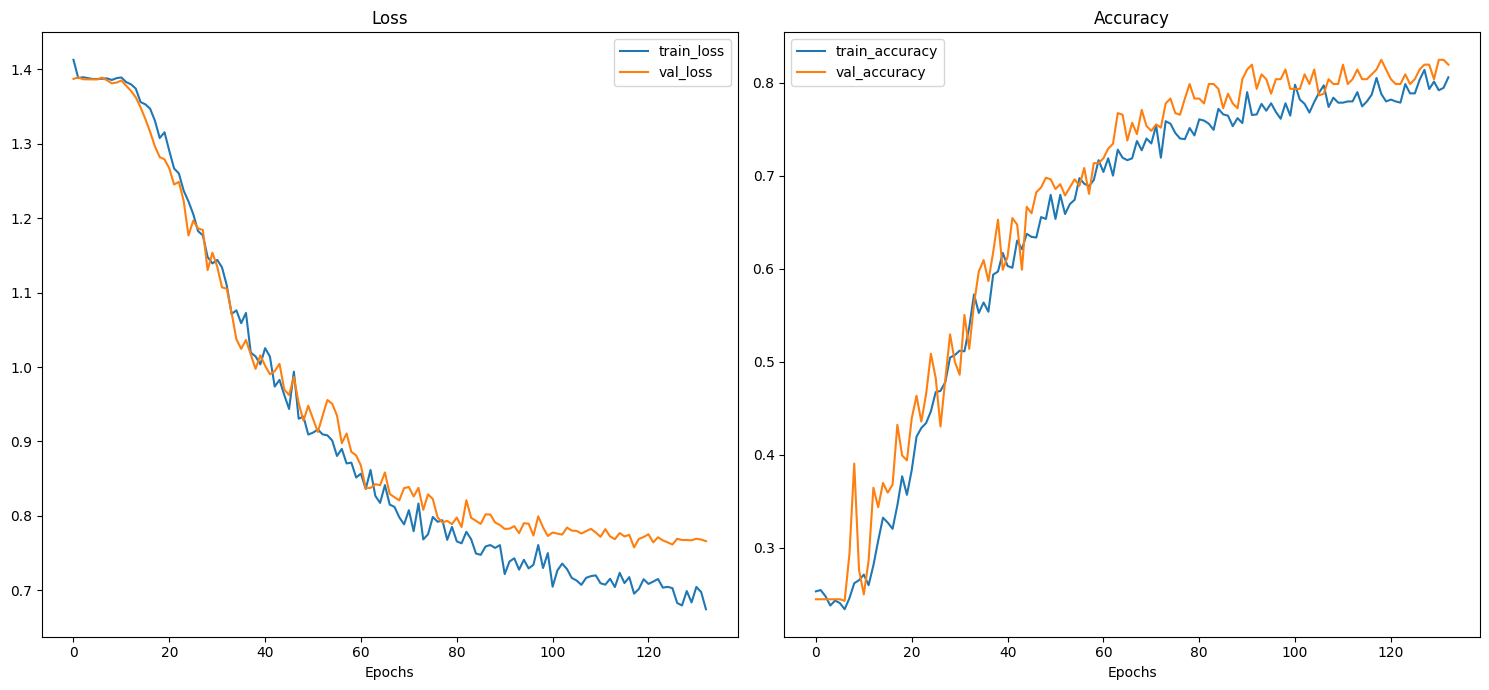

In [ ]:
plot_eval_curves(model_1_results)

In [ ]:
# test model
SAVE_PATH = Path("/content/drive/MyDrive/ml_final_assignment/models/tinyVGG_v1_2.pth")
model_v1 = TinyVGG_V1(input_shape=1, hidden_units=hidden_units, output_shape=4)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

checkpoint = torch.load(SAVE_PATH)
model_v1.load_state_dict(checkpoint["model_state_dict"])

test_loss, test_acc = test_step(dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                model=model_v1)

print(f"TEST LOSS : {test_loss} | TEST ACC : {test_acc}")

TEST LOSS : 0.6542424162228903 | TEST ACC : 0.8854166666666666


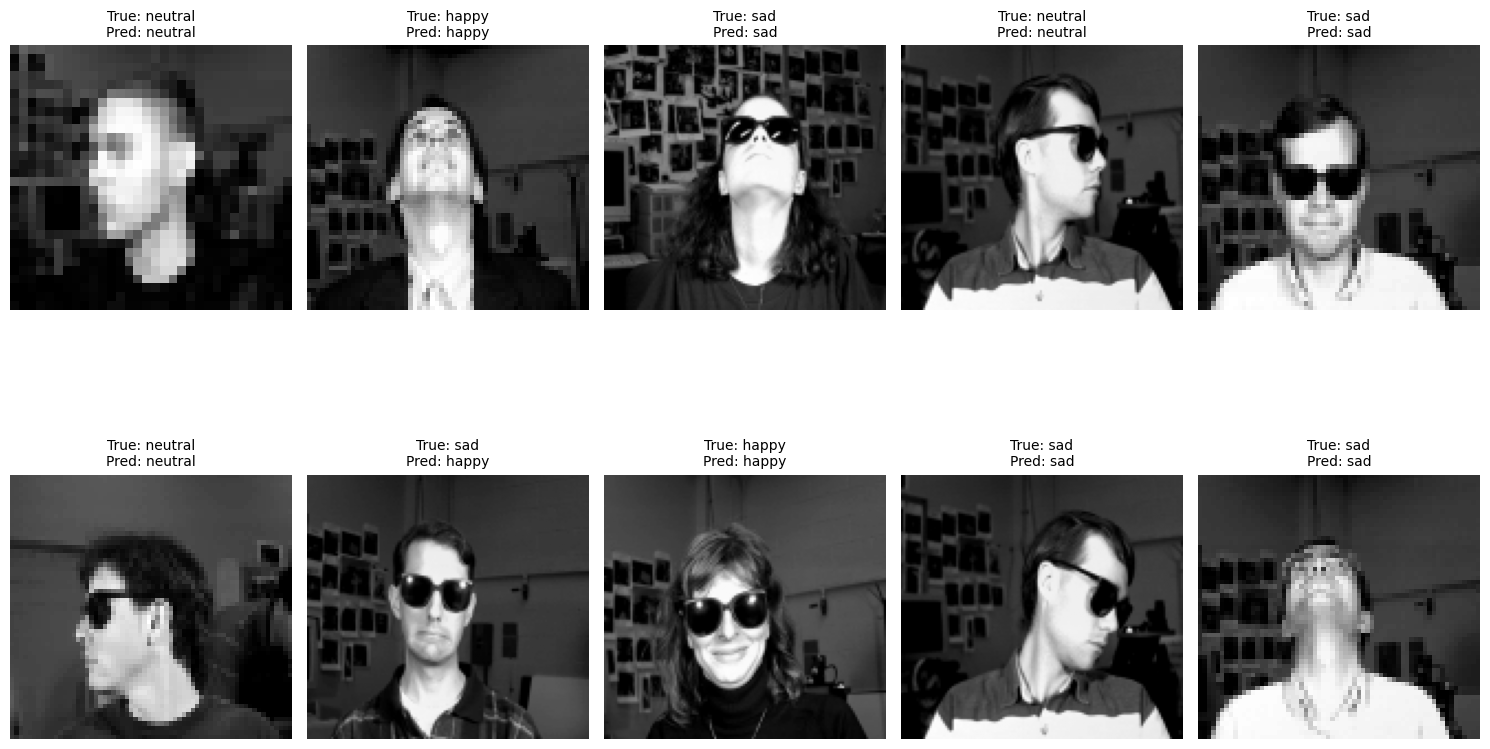

In [ ]:
import random
import torch
from PIL import Image
import matplotlib.pyplot as plt

test_dir = Path("/content/drive/MyDrive/ml_final_assignment/dataset/test")

eval_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize(size=(64, 64)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5]),
])

test_dataset = ImageFolder(root=test_dir,
                            transform=eval_transform,
                            target_transform=None,
                            allow_empty=True)

# Set model to eval mode and device
model_v1.to(device)
model_v1.eval()

# Get all image paths
class_names = test_dataset.classes

test_samples = test_dataset.samples
test_samples

# Set how many images to show
num_images = 10
plt.figure(figsize=(15, 10))

for i in range(num_images):
    # Get random image
    img_path, true_class_idx = random.choice(test_samples)
    true_class_label = class_names[true_class_idx]

    # Load and preprocess
    img = Image.open(img_path).convert("L")
    input_tensor = eval_transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model_v1(input_tensor)
        pred_class_idx = torch.argmax(output, dim=1).item()
        pred_label = class_names[pred_class_idx]

    # Plot
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true_class_label}\nPred: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()